# Identifying Risk Factors as a topic by learning from MeSH

_Jon Scott Stevens, AbbVie RAIDERS_

The CORD-19 challenge surrounds information extraction of many stripes, but I was immediately drawn to the challenge of extracting information about risk factors. My fellow RAIDERs immediately had a number of great ideas including, (1) text mining the articles using ontologies for potential risk factors, (2) applying a question answering model such as bio-BERT to allow users to ask questions like "is smoking a risk factor for COVID-19?" and (3) applying simple search tools such as AWS Kendra to the data to allow users to search for phrases like "risk factors." The question that occurred to me is whether any or all of these processes could be aided by pre-filtering the documents for their relevance to the concept of risk factors. The contribution of such a pre-filter is twofold.

1.  It could refine the information that is extracted by getting rid of irrelevant documents thereby reducing noise

2.  If the number of documents being extracted from is sufficiently shrunk, the system will become more performant 

I often find myself implementing some form of relevance-based pre-filtering in my projects for reason #2.  We want to speed up our systems and save on costs for fancy GPU hardware.

In the case of 'Risk Factors' we can determine relevance by learning from MeSH.

https://www.nlm.nih.gov/mesh/meshhome.html

I have a database of almost 30 million MEDLINE abstracts, most of which are tagged with MeSH terms, a good gold standard to use for normalized keyword annotations. There is a MeSH term 'Risk Factors'.  We can learn from the abstracts in this database to predict when 'Risk Factors' is tagged as a MeSH topic, and then apply that model to the CORD-19 abstracts, which often do not have MeSH – either because they are too new or because they are not on MEDLINE.  In doing this, we can, for example, ask questions about risk factors, and get answers much more quickly by reducing the set of answer-containing documents to only those which we are confident discuss some notion of risk factors.

Step 1 of this exercise was to create a 'Risk Factors' dataset for training and evaluation, which I am not showing here.  The result of that process is a folder full of CSV files, each one balanced, with positive and negative samples for whether 'Risk Factors' is a MeSH term.  This is what is contained in the 'risk_factors' folder -- a classic binary text classification data set with over a million data points.  More than enough to train a decent model.

## Import statements

We are using PyTorch for this exercise, including the torch.nn of TransformerEncoder to encode our abstracts.  In addition we are mostly using standard libraries, with the only esoteric one being 'pyphen', which separates out words into syllables, which I've used for my custom biomedical tokenizer, discussed briefly below.

In [ ]:
! pip install pyphen

import pandas
import math
import torch
import json
import re
import pyphen
import string
from IPython.display import clear_output
from numpy import mean
from glob import glob
from torch import nn
from torch import optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader

## Tokenization and integer coding

This is not the focus of this exercise, but I was able to adapt some simple tokenizer classes from other work, and combine them to create a transformer-friendly frequency-thresholded word and word part tokenizer which is fit to biomedical English (using word and syllable frequencies from the MEDLINE database).  Two frequency dictionaries, one for word frequencies ('text_frequencies.json') and one for word and syllable frequencies ('first_pass_tokenizer_frequencies.json') are found in the 'cache' folder and are required to instantiate the tokenizer classes.  The basic idea is to iteratively create a tokenizer using the following steps:

1. Create a "first pass" tokenizer which keeps word tokens (extracted with a simple regex) above a given frequency in MEDLINE.  Below that frequency threshold, use pyphen to split the words apart into syllables.
2. Using frequencies of both word and syllable tokens on MEDLINE create with the first pass tokenizer, again use a frequency threshold to split apart infrequency syllable tokens into their component characters.

You'll see an example of its output below.  First, let's define the necessary tokenizer classes.

In [ ]:
class RegexTokenizer:
    def __init__(self, regex=re.compile(r'\w+|\. |\.$|\b\?|\b\!'), lower=False):
        self.regex = regex
        self.lower = lower

    def tokenize(self, text):
        text = text.lower() if self.lower else text
        return self.regex.findall(text)


class SyllableTokenizer:
    def __init__(self):
        self.dic = pyphen.Pyphen(lang='en')

    def tokenize(self, word):
        return ["#" + s for s in self.dic.inserted(word).split("-")]


class CharacterTokenizer:
    def __init__(self):
        pass

    def tokenize(self, word):
        return ['#' + char for char in list(word.replace('#', ''))]


class FirstPassTokenizer:
    def __init__(self, frequency_dict, min_freq, sentence=RegexTokenizer(), word=SyllableTokenizer()):
        self.sentence = sentence
        self.word = word
        self.frequency_dict = frequency_dict
        self.min_freq = min_freq

    def tokenize(self, text):
        zeroth_pass = self.sentence.tokenize(text)
        tokens = []
        for potential_token in zeroth_pass:
            try:
                assert self.frequency_dict[potential_token] >= self.min_freq
                tokens.append(potential_token)
            except (AssertionError, KeyError):
                tokens += self.word.tokenize(potential_token)
        return tokens


class TextTokenizer:
    def __init__(self, frequency_dict,  min_freq, first_pass, character=CharacterTokenizer()):
        self.frequency_dict = frequency_dict
        self.min_freq = min_freq
        self.character = character
        self.first_pass = first_pass
        self.vocabulary = [token for token in frequency_dict.keys() if frequency_dict[token] >= min_freq]

    def tokenize(self, text):
        first_pass = self.first_pass.tokenize(text)
        tokens = []
        for potential_token in first_pass:
            try:
                assert potential_token in self.vocabulary
                tokens.append(potential_token)
            except (AssertionError, KeyError):
                tokens += self.character.tokenize(potential_token)
        return tokens


Now let's define an integer coder class to take the tokens and assign them unique integer values, allowing for padding and "cls" tokens a la BERT (which I'm not using here).

In [ ]:
class IntegerCoder:
    def __init__(self, tokenizer, pad_string="[[PAD]]", cls_string="[[CLS]]"):
        self.tokenizer = tokenizer
        self.pad_string = pad_string
        self.cls_string = cls_string
        self.vocabulary = tokenizer.vocabulary + ['#{}'.format(char) for char in string.printable]
        self.vocabulary.sort()
        self.decode_dict = dict(enumerate(self.vocabulary))
        if pad_string is not None:
            self.decode_dict[max(self.decode_dict.keys()) + 1] = pad_string
        if cls_string is not None:
            self.decode_dict[max(self.decode_dict.keys()) + 1] = cls_string
        self.encode_dict = {v: k for k, v in self.decode_dict.items()}
        self.vocab_size = len(list(self.encode_dict.keys()))

    def encode_word(self, word):
        try:
            return self.encode_dict[word]
        except KeyError:
            return self.vocab_size

    def encode(self, obj):
        if type(obj) == list:
            return [self.encode(item) for item in obj]
        elif type(obj) == str:
            return self.encode_word(obj)
        else:
            raise TypeError(
                "Argument to self.encode must be a string, list of strings, or list of lists of strings, etc.")

    def decode_integer(self, integer):
        return self.decode_dict[integer]

    def decode(self, obj):
        if type(obj) == list:
            return [self.decode(item) for item in obj]
        elif type(obj) == int:
            return self.decode_integer(obj)
        else:
            raise TypeError("Argument to self.decode must be an int, list of ints, list of lists of ints, etc.")
            

Now we instantiate those classes to create a tokenizer and coder for text input.

In [ ]:
with open('../input/frequency-dictionaries-for-biomedical-tokenizer/text_frequencies.json', 'r') as f:
    text_frequencies = json.load(f)

with open('../input/frequency-dictionaries-for-biomedical-tokenizer/first_pass_tokenizer_frequencies.json', 'r') as f:
    first_pass_frequencies = json.load(f)

first_pass_tokenizer = FirstPassTokenizer(text_frequencies, min_freq=10000)

tokenizer = TextTokenizer(first_pass_frequencies, min_freq=10000, first_pass=first_pass_tokenizer)
    
text_coder = IntegerCoder(tokenizer)

Below I define and give example outputs for two functions which use the above-defined classes to create sequences of tokens from text inputs, and also integer codings of them, with a given fixed sequence length.

In [ ]:
def sequentialize(text, seq_length):
    tokens = tokenizer.tokenize(text)
    if len(tokens) >= seq_length:
        return tokens[0:seq_length]
    else:
        return tokens + [text_coder.pad_string] * (seq_length - len(tokens))


def numericalize(text, seq_length=256):
    return torch.tensor(text_coder.encode(sequentialize(str(text), seq_length)))


print(tokenizer.tokenize("This is a test of the numericalization function."))
print(numericalize("This is a test of the numericalization function.", 15))

## Data loader

One aspect of PyTorch that I've been wanting to learn is how Dataset and DataLoader objects work.  In the past, I have done the work of loading my data and converting to tensors mostly from scratch, and probably in an unoptimized way compared to what comes bundled with PyTorch.  With some ease I was able to get a DataLoader which will abstracts and labels from multiple CSV files and create batched tensors of any given batch size.  You first create a Dataset sub-class, where you define the len and get_item methods.  In my case I needed to read from an arbitrarily large number of different CSVs (I created the data set in this way to avoid pulling overly large batches of documents from the database, and to keep file sizes down).  So when I initialize my custom Dataset sub-class, I load the CSVs in a given directory using pandas, then define get_item such that it takes a single index (e.g. get me the 1533rd data point) and locates the right CSV and index for that individual file (e.g., pull the 15th row of the 2nd CSV in the directory).  It then applies the tokenizer and integer coder to convert the text of each abstract into a tensor.  A DataLoader object, then, references this Dataset sub-class, and layers on top of it a "batchification" functionality.  Thus, I can create a DataLoader with a given batch size, and I can iterate through that object to pull batches of abstracts in tensor form (i.e., of dimension batch size x max sequence length).

Here first is the Dataset sub-class, MeshSamples:

In [ ]:
class MeshSamples(Dataset):
    def __init__(self, directory, subdirectory, X_col='abstract', y_col=None):
        self.directory = directory
        self.subdirectory = subdirectory
        self.X_col = X_col
        self.y_col = y_col if y_col else self.directory
        self.files = glob("../input/data-for-learning-from-mesh-risk-factors/{}/{}/*.csv".format(self.directory, self.subdirectory))
        self.dfs = [pandas.read_csv(f) for f in self.files]
        self.lengths = [len(df) for df in self.dfs]
        self.length = sum(self.lengths)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        a, b = self.get_coordinates(index)
        df = self.dfs[a]
        X = numericalize(df[self.X_col][b])
        y = df[self.y_col][b]
        return X, y
        
    def get_coordinates(self, index):
        total = 0
        for i, length in enumerate(self.lengths):
            old_total = total
            total += length
            if index < total:
                return i, index - old_total
        return None
        
    
ms = MeshSamples('risk_factors', 'train')

Now we make a DataLoader to do the batchification for us!

In [ ]:
dl = DataLoader(ms, batch_size=1024, shuffle=True, num_workers=0, pin_memory=True)
next(iter(dl))

## The model

There are lots of things I could have done at this point.  I ended up training a small transformer model, knowing that for binary text classification transformers are likely overkill. I did it the way I did it mainly as a learning exercise – another learning goal of mine was to play with the torch.nn implementation of TransformerEncoder.  I learned some good lessons about it, namely that (1) the TransformerEncoder does not "come with" an initial embedding layer – you need to add that to the model yourself, and (2) positional encodings (the additional embeddings that use sine/cosine functions to encode where in the sequence a token is located) are also not included.  I used the PositionalEncodings implementation from PyTorch's transformer tutorial here:  https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [ ]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


We now define the model, a transformer classifier, which looks like this:
* Input layer
* Embedding layer (50-dimensional)
* Positional encodings (with max sequence length 256)
* Transformer encoder to transform embeddings after positional enrichment (with just a single attention head, given this is a smaller model)
* Document embedding layer which takes the mean of the transformed embeddings
* Sigmoid output layer for binary class prediction (in this case where the binary label will be 1 for 'Risk Factors' being a topic, 0 for not.

In [ ]:

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, nhead, nhid, nlayers, dropout=0):
        super(TransformerClassifier, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, dropout)
        encoder_layers = TransformerEncoderLayer(embedding_size, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(vocab_size, embedding_size)
        self.embedding_size = embedding_size
        self.output = nn.Linear(embedding_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.output.bias.data.zero_()
        self.output.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.embedding_size)
        src = self.pos_encoder(src)
        encoded = self.transformer_encoder(src)
        cls = encoded.mean(1)
        output = self.sigmoid(self.output(cls)).flatten()
        return output

num_types = len(text_coder.vocabulary) + 2
tc = TransformerClassifier(num_types, 50, 1, 10, 1).to('cuda')
print(tc)

## Train the model

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(tc.parameters(), lr=0.01)
losses = []
accuracies = []
num_batches = 500

for i, batch in enumerate(dl):
    if i < num_batches:
        X = batch[0].to('cuda')
        y = batch[1].float().to('cuda')
        y_pred = tc.forward(X)
        loss = criterion(y_pred,y)
        losses.append(loss.item())
        accuracy = (((y_pred >= 0.5) & (y >= 0.5)).sum() + ((y_pred < 0.5) & (y < 0.5)).sum()).item()
        accuracy = accuracy / y.shape[0]
        accuracies.append(accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        clear_output()
        print("Batch {} loss {} accuracy {} cumacc {}".format(i + 1, loss.item(), accuracy, mean(accuracies)))
    else:
        break

torch.save(tc, 'tc.pt')
torch.save(tc.state_dict(), 'tc.pth')

## Evaluate model on held-out test set

Recall that the datasets are balanced, so accuracy is meaningful.  Accuracy on the held-out test set is typically around 90%.

In [ ]:
test_ms = MeshSamples('risk_factors', 'test')
test_dl = DataLoader(test_ms, batch_size=dl.batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
test_accuracies = []

for i, batch in enumerate(test_dl):
    clear_output()
    print(i)
    X = batch[0].to('cuda')
    y = batch[1].float().to('cuda')
    y_pred = tc.forward(X)
    accuracy = (((y_pred >= 0.5) & (y >= 0.5)).sum() + ((y_pred < 0.5) & (y < 0.5)).sum()).item() / test_dl.batch_size
    test_accuracies.append(accuracy)

print(mean(test_accuracies))

## Add inferences to CORD-19 abstract data

So now we have a model that will predict with (for this run) 89% accuracy whether 'Risk Factors' is a topic, which we can use to produce a "risk_factors" score between 0 and 1.  We close out this exercise by adding those scores to the abstract data ('cord.txt'), which was pulled from the 'metadata' file provided as part of the CORD-19 dataset.

In [ ]:
cord = pandas.read_csv('../input/cord19-abstracts/cord.txt', sep='\t')

scores = []

for i, abstract in enumerate(cord['abstract']):
    clear_output()
    print(i)
    numericalized = numericalize(abstract)
    reshaped = numericalized.view(1, numericalized.shape[0]).to('cuda')
    scores.append(tc.forward(reshaped).item())
        
cord['risk_factors'] = scores

cord.to_csv('cord_enhanced.csv')

Titles of records in the top 1000 'risk_factors'-sorted articles which contain "COVID":

In [ ]:
[title for title in cord.sort_values('risk_factors', ascending=False).head(1000)['title'] if 'COVID' in title]

## What is a model like this good for?

There are a number of potential use cases for being able to predict relevance to a given MeSH term.  For the CORD-19 dataset in particular, one avenue we are exploring is using MeSH concept relevance ranking to refine and shrink the document set used by a question answering system.  Models like BERT and BioBERT are much more performant, and also give less noisy answers, if their contexts are derived from a more focused document set.  If we want to ask questions specifically about Risk Factors of COVID-19, we can first pre-filter our document set into a much smaller set -- say, the top thousand abstracts out of over 30,000 -- and go from there.  Here are the top results from using BioBERT to ask these top thousand CORD-19 abstracts the question, "What are risk factors for COVID-19?"

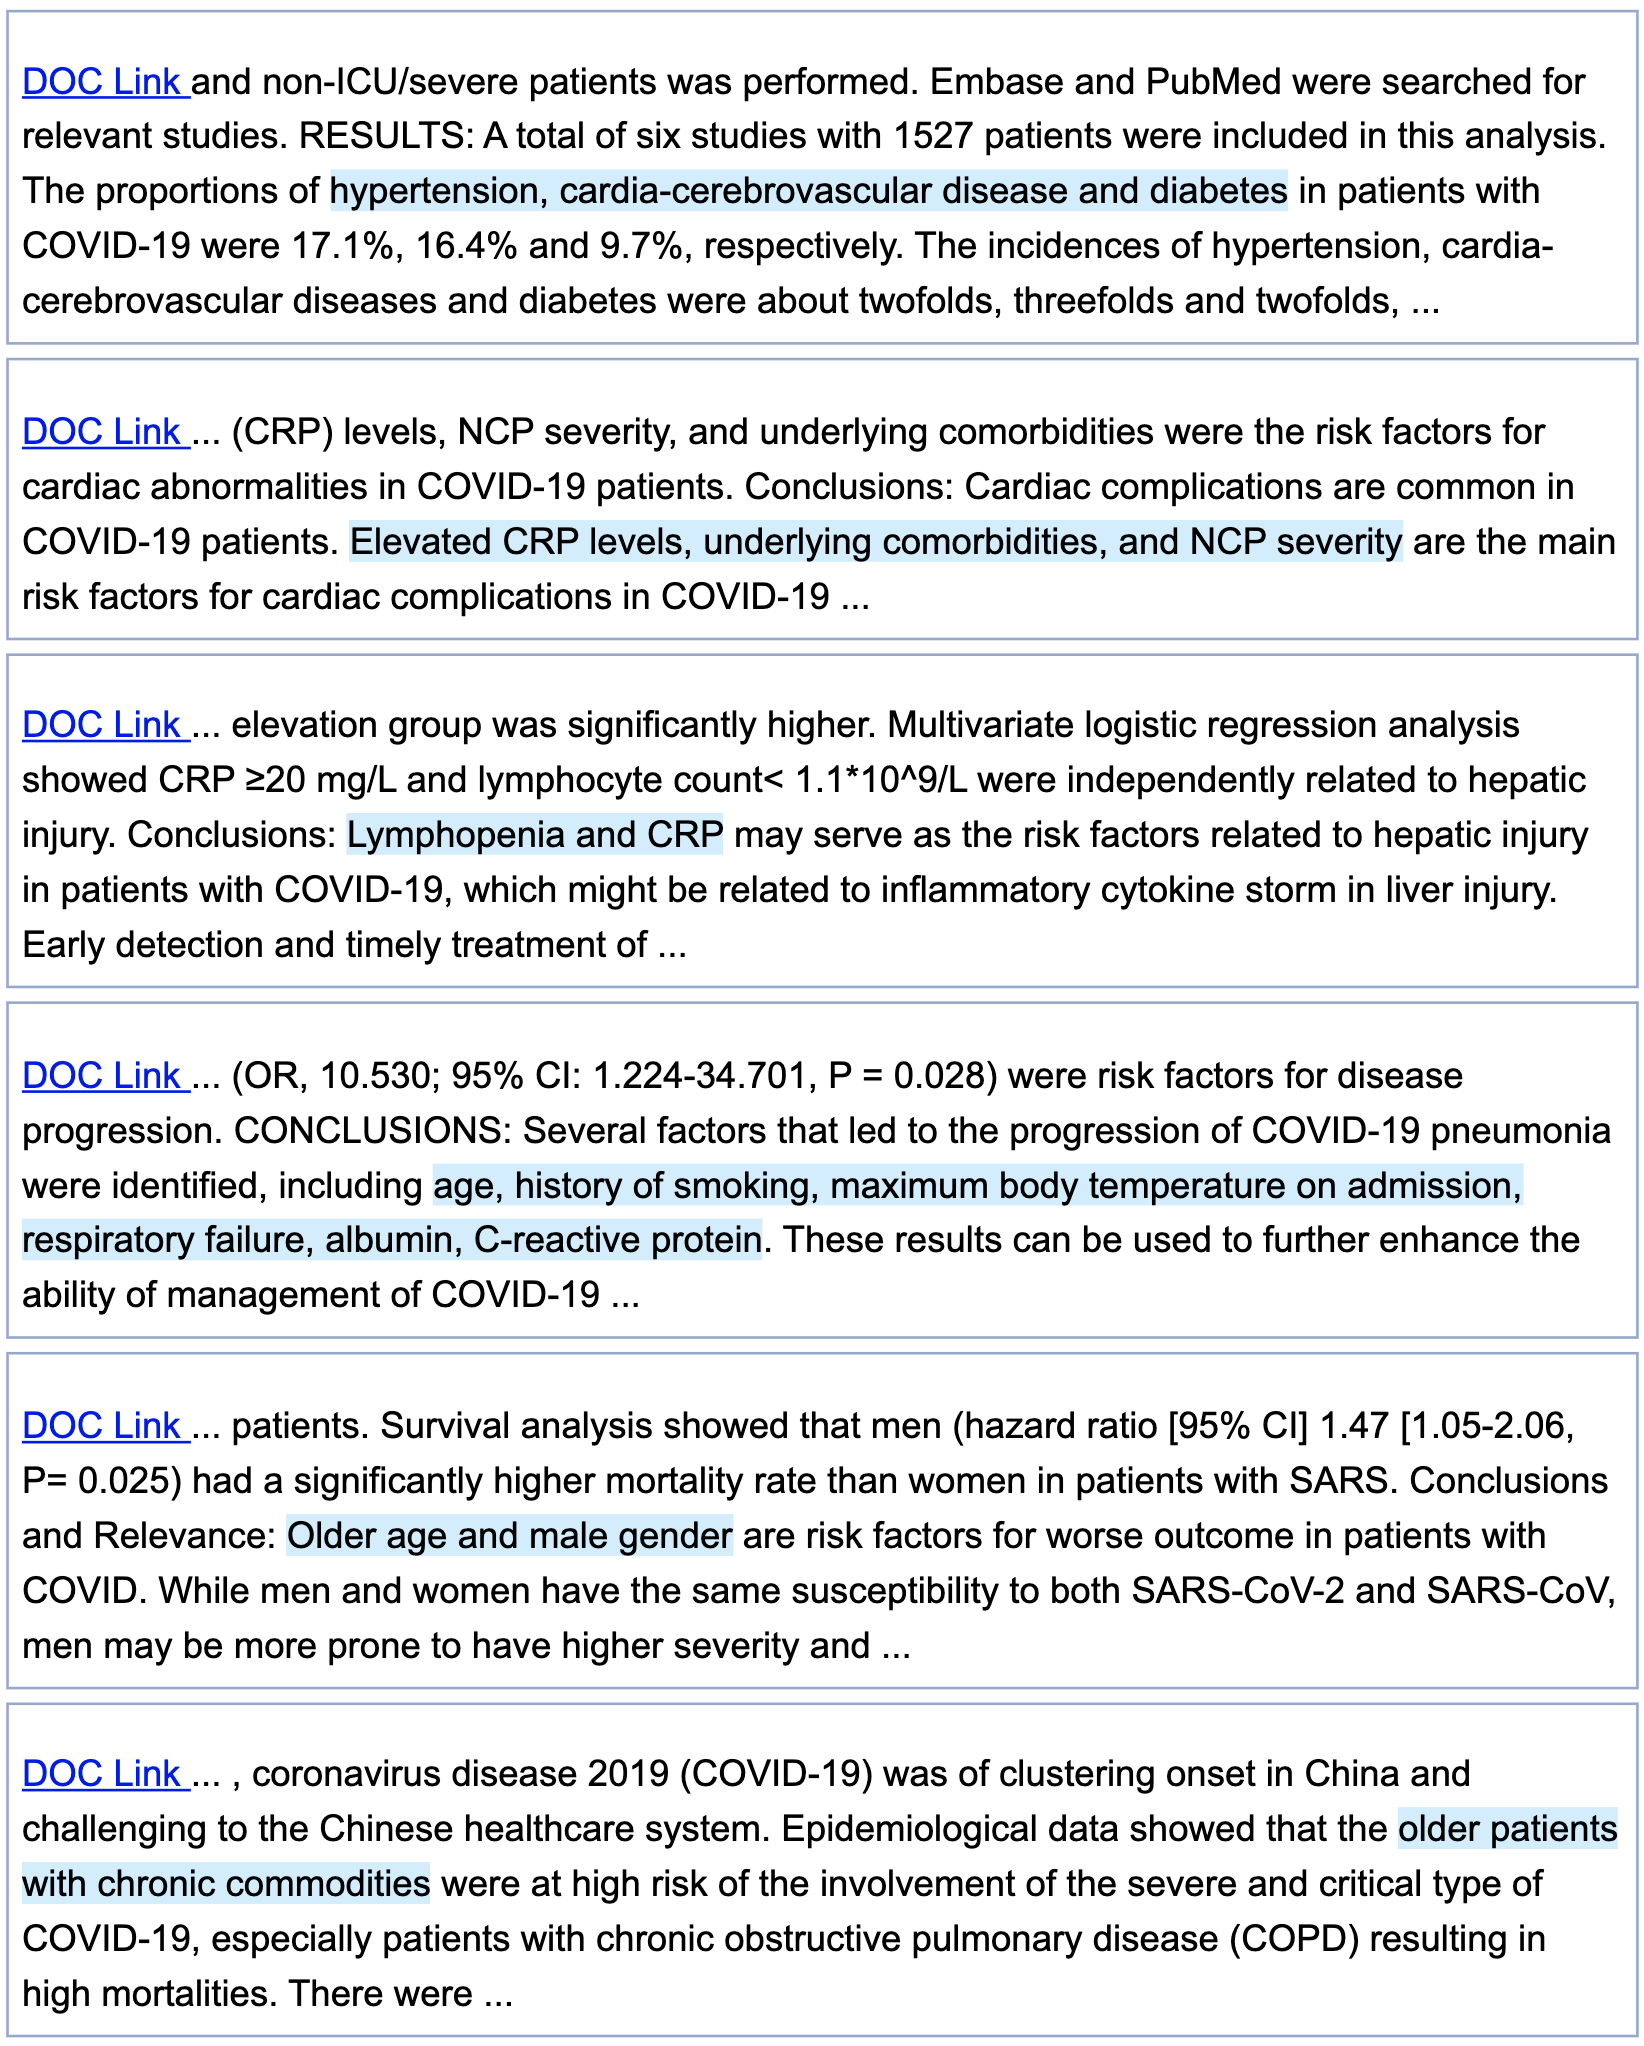

We are only just beginning to experiment with the possible uses of models like this, but one thing that is clear is that we are not limited to Risk Factors.  For example, I've already deployed a model for the MeSH concept 'Drug Design', trained on over 100k abstracts, evaluated with over 91% accuracy, to create a literature collection containing potential drug targets.  Hopefully, others will find it useful to use NLP and learning from MeSH to help extract valuable information from biomedical literature.